# Check the biological validity of SEMITONES selected peaks

In this notebook, we explore metrics to quantify how well SEMITONES-selected peaks are able to recapitulate known biology.

## 1. Set up the notebook and scoring functions

### a. Load packages

In [1]:
import itertools
import numpy as np
import os
import pandas as pd
import pickle

from matplotlib import pyplot as plt
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import load_sparse_h5
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.tfidf import TFIDF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from umap import UMAP

### b. Define functions

In [2]:
def binarize(X, t):
    X = X.copy()
    condition = X.data > t
    X.data[condition] = 1
    X.data[np.logical_not(condition)] = 0
    return X

## 2. Perform feature selection and evaluate
The features are selected and density index computation is ran in paper_n_evaluate_ATAC.py

### a. Load needed data

#### i. Enrichment scores and null distributions

In [3]:
escores = pd.read_csv(
    "../data/processed/greenleaf_scATAC_escores_knn_rbf_8e-1_nonhvorc.txt",
    sep="\t", index_col=0)
pscores = pd.read_csv(
    "../data/interim/greenleaf_scATAC_pscores_knn_rbf_8e-1_nonhvorc.txt",
    sep="\t", index_col=0)

#### ii. scATAC-seq count matrix

In [4]:
X = load_sparse_h5(
    "scATAC", "../data/interim/greenleaf_scATAC_peaks_filtered.h5"
)

In [5]:
X = binarize(X, 0)  # binarize

In [6]:
# peak labels
with open("../data/interim/greenleaf_scATAC_peaks_filtered.txt", "r") as f:
    peaks = [g.strip("\n") for g in f.readlines()]
f.close()

In [7]:
# cell barcodes
with open("../data/processed/greenleaf_scATAC_filtered_barcodes.txt", "r") as f:
    barcodes = [b.strip("\n") for b in f.readlines()]
f.close()

### b. Get top SEMITONES ranked genes
We do this interactively in the notebook to get the right s.t.d. away from the mean values.

In [8]:
n_sds = [54.43, 36.5751, 31.003, 18.7243, 13.9994]
n_peaks = [500, 5000, 10000, 50000, 100000]
for n_sd, n_peak in zip(n_sds, n_peaks):
    
    s = sig_interval(pscores, n_sds=n_sd)  # get signficance interval
    s = sig_dictionary(escores, s)  # get signficant peaks

    s_peaks = []
    for k, v in s.items():  # for each cell, signficant peaks
        s_peaks.extend(v)  # add peak s_peaks
    s_peaks = list(set(s_peaks))  # only keep unique elements
    # save the results in a pickle dump
    filename = f"semitones_ranked_feature_selection_{n_peak}_ATAC.pkl"
    with open(f"{filename}", "wb") as f:
        pickle.dump(s_peaks, f)
    f.close()
    print(len(s_peaks))  # check how many peaks selected

500
5000
10000
50000
100000


### b. Plot density indices

In [9]:
with open("density_indices_ATAC.pkl", "rb") as f:
    dis = pickle.load(f)
f.close()

In [10]:
dis = pd.DataFrame(dis)
dis = dis.reindex(["semitones", "sem_rank", "top_peaks"])

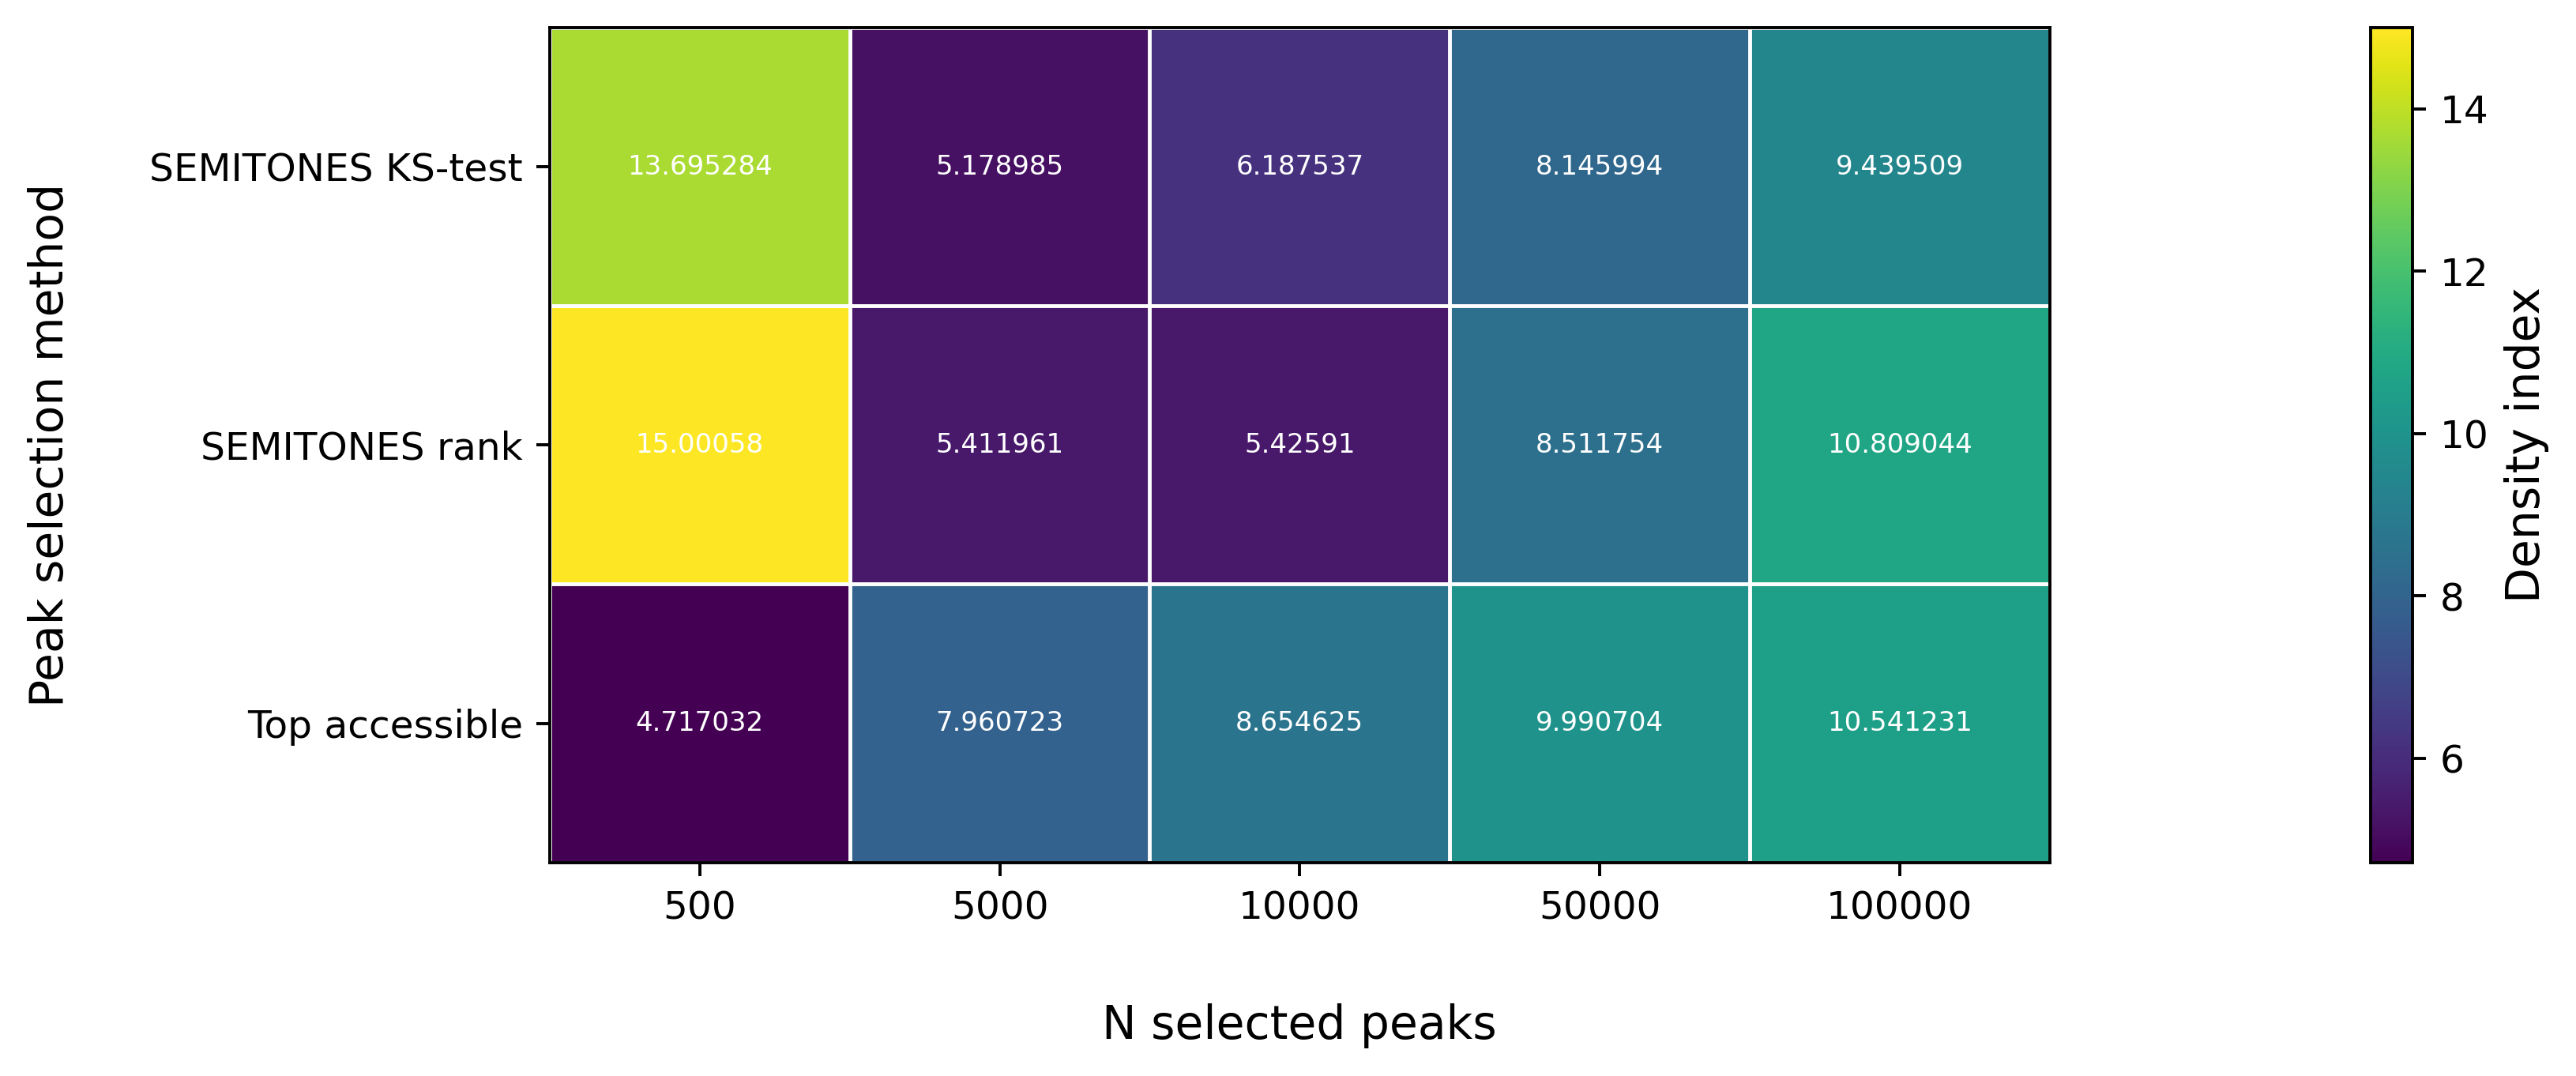

In [11]:
plt.figure(figsize=(10, 4), dpi=350)
plt.imshow(dis, aspect="auto")
cbar = plt.colorbar(pad=.15)
cbar.ax.set_ylabel("Density index", fontsize=12)
ax = plt.gca()

nrows, ncols = 3, 5

ax.set_xticks(range(ncols))
ax.set_xticklabels(dis.keys())
ax.set_xlabel("N selected peaks", labelpad=20, fontsize=12)

methods = ["SEMITONES KS-test", "SEMITONES rank", "Top accessible"]
ax.set_yticks(range(nrows))
ax.set_yticklabels(methods)
ax.set_ylabel("Peak selection method", labelpad=20, fontsize=12)

# create text annotations
for i in range(nrows):
    for j in range(ncols):
        text = ax.text(j, i, round(dis.iloc[i, j], 6),
                       ha="center", va="center", color="w",
                       fontsize=7)

ax.set_xticks(np.arange(ncols+1)-.5, minor=True)
ax.set_yticks(np.arange(nrows+1)-.5, minor=True)
ax.grid(b=True, which="minor", axis="both", color="white", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

### c. Silhouette coefficient

#### i. Get the annotations from the metadata

In [12]:
# load the metadata
metadata = pd.read_csv(
    "../data/external/greenleaf_scATAC_cell_metadata.txt",
    sep="\t")

# get the barcodes for the right order
with open("../data/processed/greenleaf_scATAC_filtered_barcodes.txt", "r") as f:
    barcodes = [b.strip("\n") for b in f.readlines()]
f.close()

metadata = metadata.reindex(barcodes)  # arrange metadata in order of SVDs
# select the biological annotations from Granja et al. 2019
annots = metadata.BioClassification.values
mapping = dict(enumerate(np.unique(annots)))  # map each annot to a unique id
mapping = {v: k for k, v in mapping.items()}  # reverse the mapping
annots = [mapping[i] for i in annots]  # numerical id for each annotation

#### ii. Get the file names for the 50 SVD components

In [13]:
files = os.listdir()
files = [f for f in files if ("svd50" in f) & ("peaks" in f)]
files.sort()

In [14]:
files

['sem_rank_svd50_100000peaks.npy',
 'sem_rank_svd50_10000peaks.npy',
 'sem_rank_svd50_50000peaks.npy',
 'sem_rank_svd50_5000peaks.npy',
 'sem_rank_svd50_500peaks.npy',
 'semitones_svd50_100000peaks.npy',
 'semitones_svd50_10000peaks.npy',
 'semitones_svd50_50000peaks.npy',
 'semitones_svd50_5000peaks.npy',
 'semitones_svd50_500peaks.npy',
 'top_peaks_svd50_100000peaks.npy',
 'top_peaks_svd50_10000peaks.npy',
 'top_peaks_svd50_50000peaks.npy',
 'top_peaks_svd50_5000peaks.npy',
 'top_peaks_svd50_500peaks.npy']

In [15]:
methods = [f.split("_")[0] for f in files]  # get method from file name
methods = ["sem_rank" if m == "sem" else m for m in methods]  # replace "sem"
methods = [methods[0], methods[5], methods[10]]  # one each

In [16]:
methods  # check that they are in order of files

['sem_rank', 'semitones', 'top']

In [17]:
n_peaks = [f.split("_")[-1].strip("peaks.npy") for f in files]  # get n peaks
n_peaks = n_peaks[0:5]  # select first 5

In [18]:
n_peaks  # check that they are in order of files

['100000', '10000', '50000', '5000', '500']

#### iii. Compute the Silhouette score
Labels are the biological annotations. The scores are computed over the top 50 SVD components.

In [19]:
silscores = []  # save scores
for file in files:
    # load top 50 SVD components
    svd50 = np.load(f"{file}")
    silscores.append(silhouette_score(svd50, annots))  # compute score

In [20]:
# organize scores in a dataframe
silscores = pd.DataFrame([silscores[0:5], silscores[5:10], silscores[10:15]])

In [21]:
silscores  # check structure

,0,1,2,3,4
0,0.189247,0.085017,0.224656,0.015273,-0.394302
1,0.205985,0.139561,0.201990,0.057330,-0.374583
2,0.135209,-0.019792,0.106819,-0.072714,-0.166814


In [22]:
silscores.index = methods  # index the dataframe
silscores.columns = n_peaks  # provide column names for dataframe
silscores  # check indexing

,100000,10000,50000,5000,500
sem_rank,0.189247,0.085017,0.224656,0.015273,-0.394302
semitones,0.205985,0.139561,0.201990,0.057330,-0.374583
top,0.135209,-0.019792,0.106819,-0.072714,-0.166814


In [23]:
# put the columns in order of peak number
silscores = silscores.loc[:, ["500", "5000", "10000", "50000", "100000"]]

In [24]:
# put the index in order of the DI plot
silscores = silscores.loc[["semitones", "sem_rank", "top"], :]

In [25]:
silscores  # check dataframe

,500,5000,10000,50000,100000
semitones,-0.374583,0.057330,0.139561,0.201990,0.205985
sem_rank,-0.394302,0.015273,0.085017,0.224656,0.189247
top,-0.166814,-0.072714,-0.019792,0.106819,0.135209


#### iv. Plot the Silhouette scores

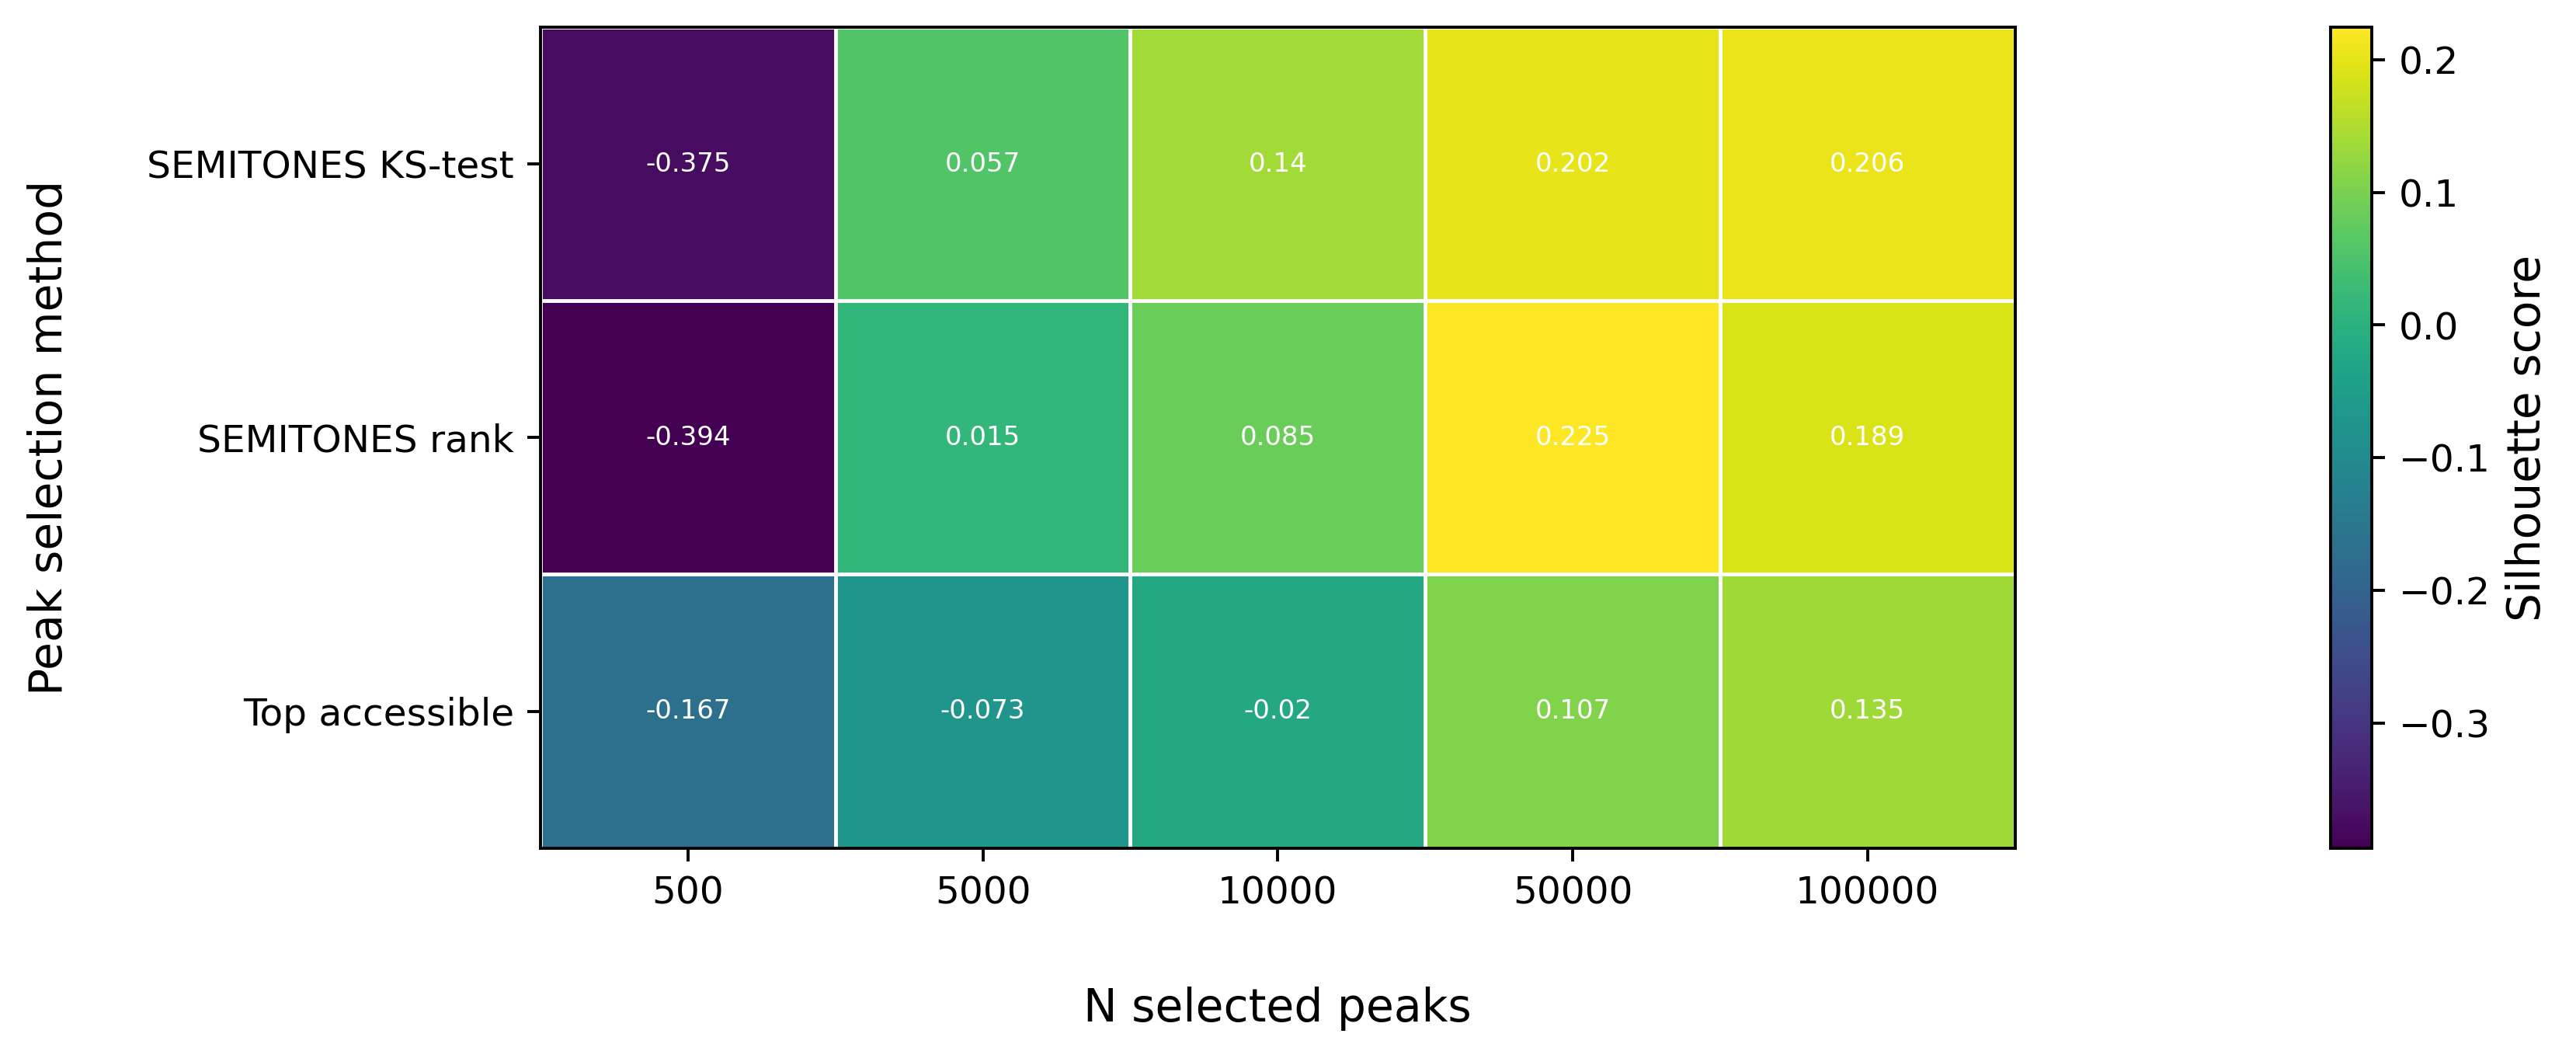

In [26]:
plt.figure(figsize=(10, 4), dpi=350)
plt.imshow(silscores, aspect="auto")
cbar = plt.colorbar(pad=.15)
cbar.ax.set_ylabel("Silhouette score", fontsize=12)
ax = plt.gca()

nrows, ncols = 3, 5

ax.set_xticks(range(ncols))
ax.set_xticklabels(silscores.columns)
ax.set_xlabel("N selected peaks", labelpad=20, fontsize=12)

methods = ["SEMITONES KS-test", "SEMITONES rank", "Top accessible"]
ax.set_yticks(range(nrows))
ax.set_yticklabels(methods)
ax.set_ylabel("Peak selection method", labelpad=20, fontsize=12)

# create text annotations
for i in range(nrows):
    for j in range(ncols):
        text = ax.text(j, i, round(silscores.iloc[i, j], 3),
                       ha="center", va="center", color="w",
                       fontsize=7)

ax.set_xticks(np.arange(ncols+1)-.5, minor=True)
ax.set_yticks(np.arange(nrows+1)-.5, minor=True)
ax.grid(b=True, which="minor", axis="both", color="white", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

### d. Plot a 2D UMAP computed using only significantly enriched peaks

#### i. Subset count matrix for signficant peaks

In [27]:
cutoffs = sig_interval(pscores, n_sds=20)
sigdict = sig_dictionary(escores, cutoffs)
regs = set(itertools.chain(*sigdict.values()))

In [28]:
keep_peaks = [peaks.index(i) for i in regs]
X_sig = X[:, keep_peaks]

In [29]:
X_sig.shape

(35022, 41881)

#### ii. LSI

In [30]:
tfidf = TFIDF(X_sig)
svd25 = TruncatedSVD(n_components=25).fit_transform(tfidf)  # only 25 components

#### iii. Compute and save UMAP

In [31]:
umap = UMAP().fit_transform(svd25)  # default params

In [32]:
# save UMAP
np.save("../data/processed/scATAC_combined_umap_SEMITONES_top.npy", umap)

#### iv. Visualize UMAP

In [33]:
persianorange =  "#d99058"
cplblue2 =       "#374350"
chesnut =        "#cd5c5c"
rosequartz =     "#aa98a9"
oldmauve =       "#673147"
oldrose =        "#c08081"
antiquefuchsia = "#915c83"
oldlavender =    "#796878"
pastelblue =     "#aec6cf"
babyblue =       "#a1caf1"
glaucous =       "#6082b6"
cambridge =      "#a3c1ad"
asparagus =      "#87a96b"
greyasparagus =  "#465945"
arylide =        "#e9dc9f"
oldgold =        "#d6bf4c"
orangeyellow =   "#e5a327"
brass =          "#b5a642"
olive =          "#808000"
clpblue =        "#3e4b59"
lavender =       "#e6e6fa"
teal =           "#469990"
pink =           "#fabebe"
brown =          "#a52a2a"
khaki =          "#c3b091"
orange =         "#e59400"

colors = [khaki,
          chesnut, brown,
          orange, arylide, clpblue,
          persianorange, orangeyellow,
          asparagus, teal,
          olive, brass, oldgold,
          greyasparagus,
          cplblue2,
          glaucous, babyblue, pastelblue,
          oldmauve, oldlavender, antiquefuchsia, rosequartz, oldrose, pink,
          lavender, greyasparagus]

# load the labels
metadata = pd.read_csv("../data/external/greenleaf_scATAC_cell_metadata.txt",
                       sep="\t")

# create a color code for the biological labels
bio_labels = metadata.loc[barcodes].BioClassification.values
bio_coldict = dict(zip(np.unique(bio_labels), colors))
bio_color = bio_labels
for l, c in bio_coldict.items():
    bio_color = [c if i == l else i for i in bio_color]
bio_legend = {k: bio_coldict[k] for k in np.unique(bio_labels)}
bio_marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="")
              for c in bio_legend.values()]

# create a color code for the sample labels
smp_labels = metadata.loc[barcodes].Group.values
smp_labels = [g.split("_")[0] for g in smp_labels]
smp_coldict = dict(zip(np.unique(smp_labels), colors))
smp_color = smp_labels
for l, c in smp_coldict.items():
    smp_color = [c if i == l else i for i in smp_color]
smp_legend = {k: smp_coldict[k] for k in np.unique(smp_labels)}
smp_marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="")
              for c in smp_legend.values()]

/home/hvlot/miniconda3/envs/hcv2_py3env/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


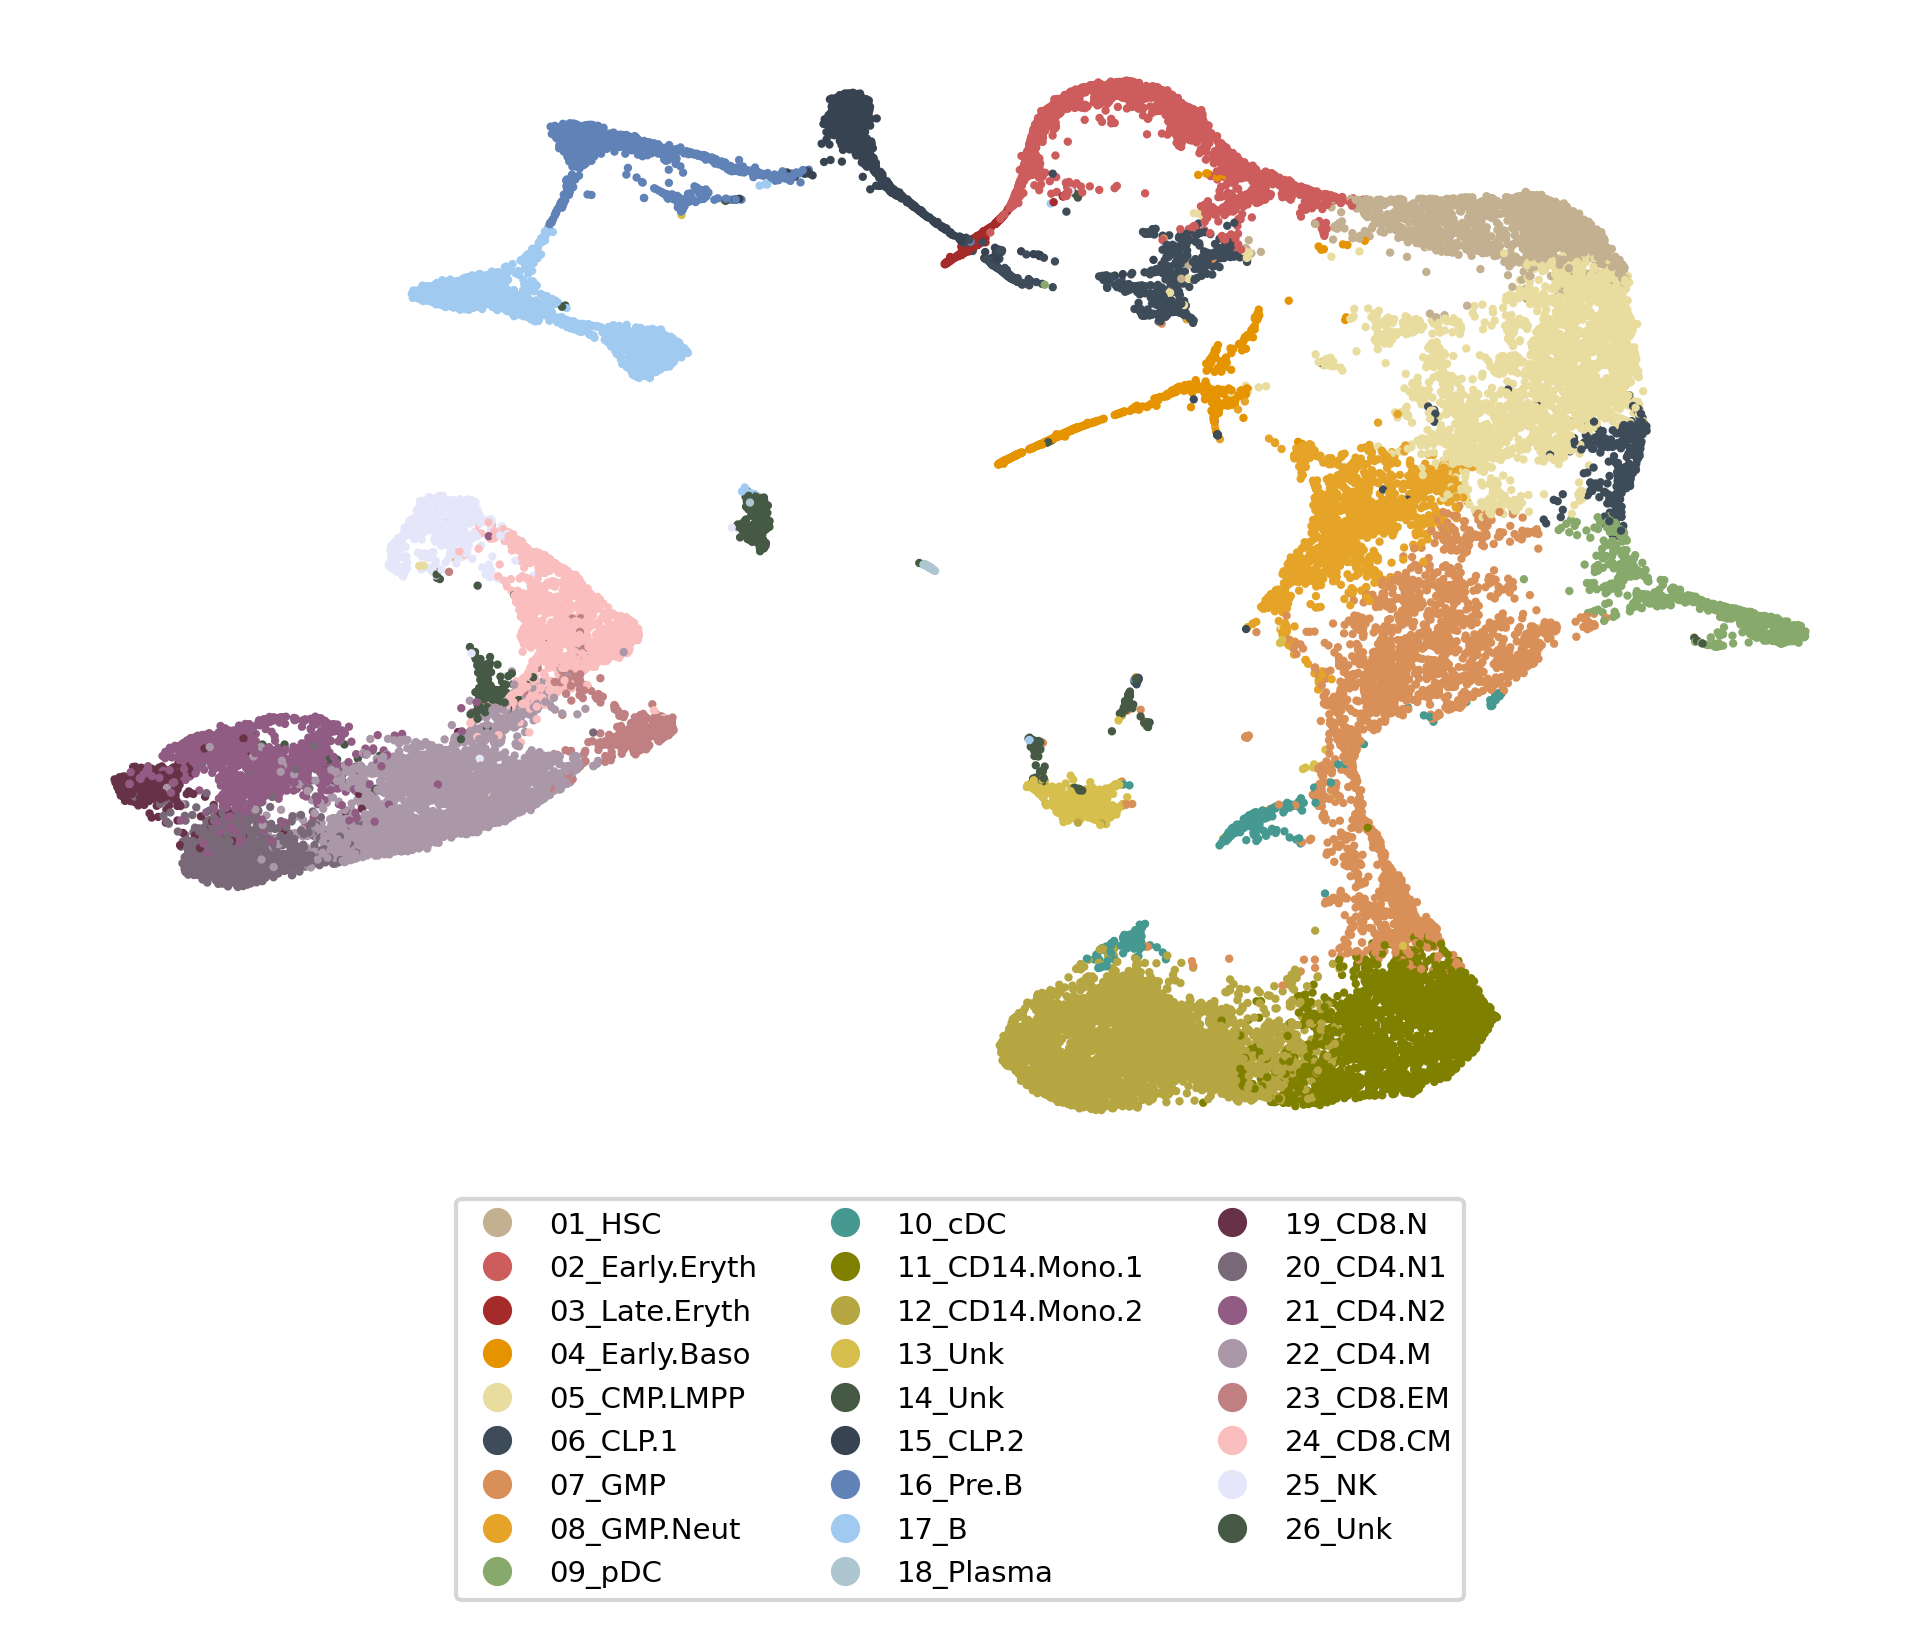

In [34]:
plt.figure(figsize=(8, 5), dpi=300)
plt.scatter(x=umap[:, 0], y=umap[:, 1], s=1, c=bio_color)
plt.legend(bio_marker, bio_legend.keys(), numpoints=0.2, fontsize=7, ncol=3,
           loc="lower center", bbox_to_anchor=(0.5, -0.4))

ax = plt.axes()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

#### v. Compare to original UMAP

/home/hvlot/miniconda3/envs/hcv2_py3env/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


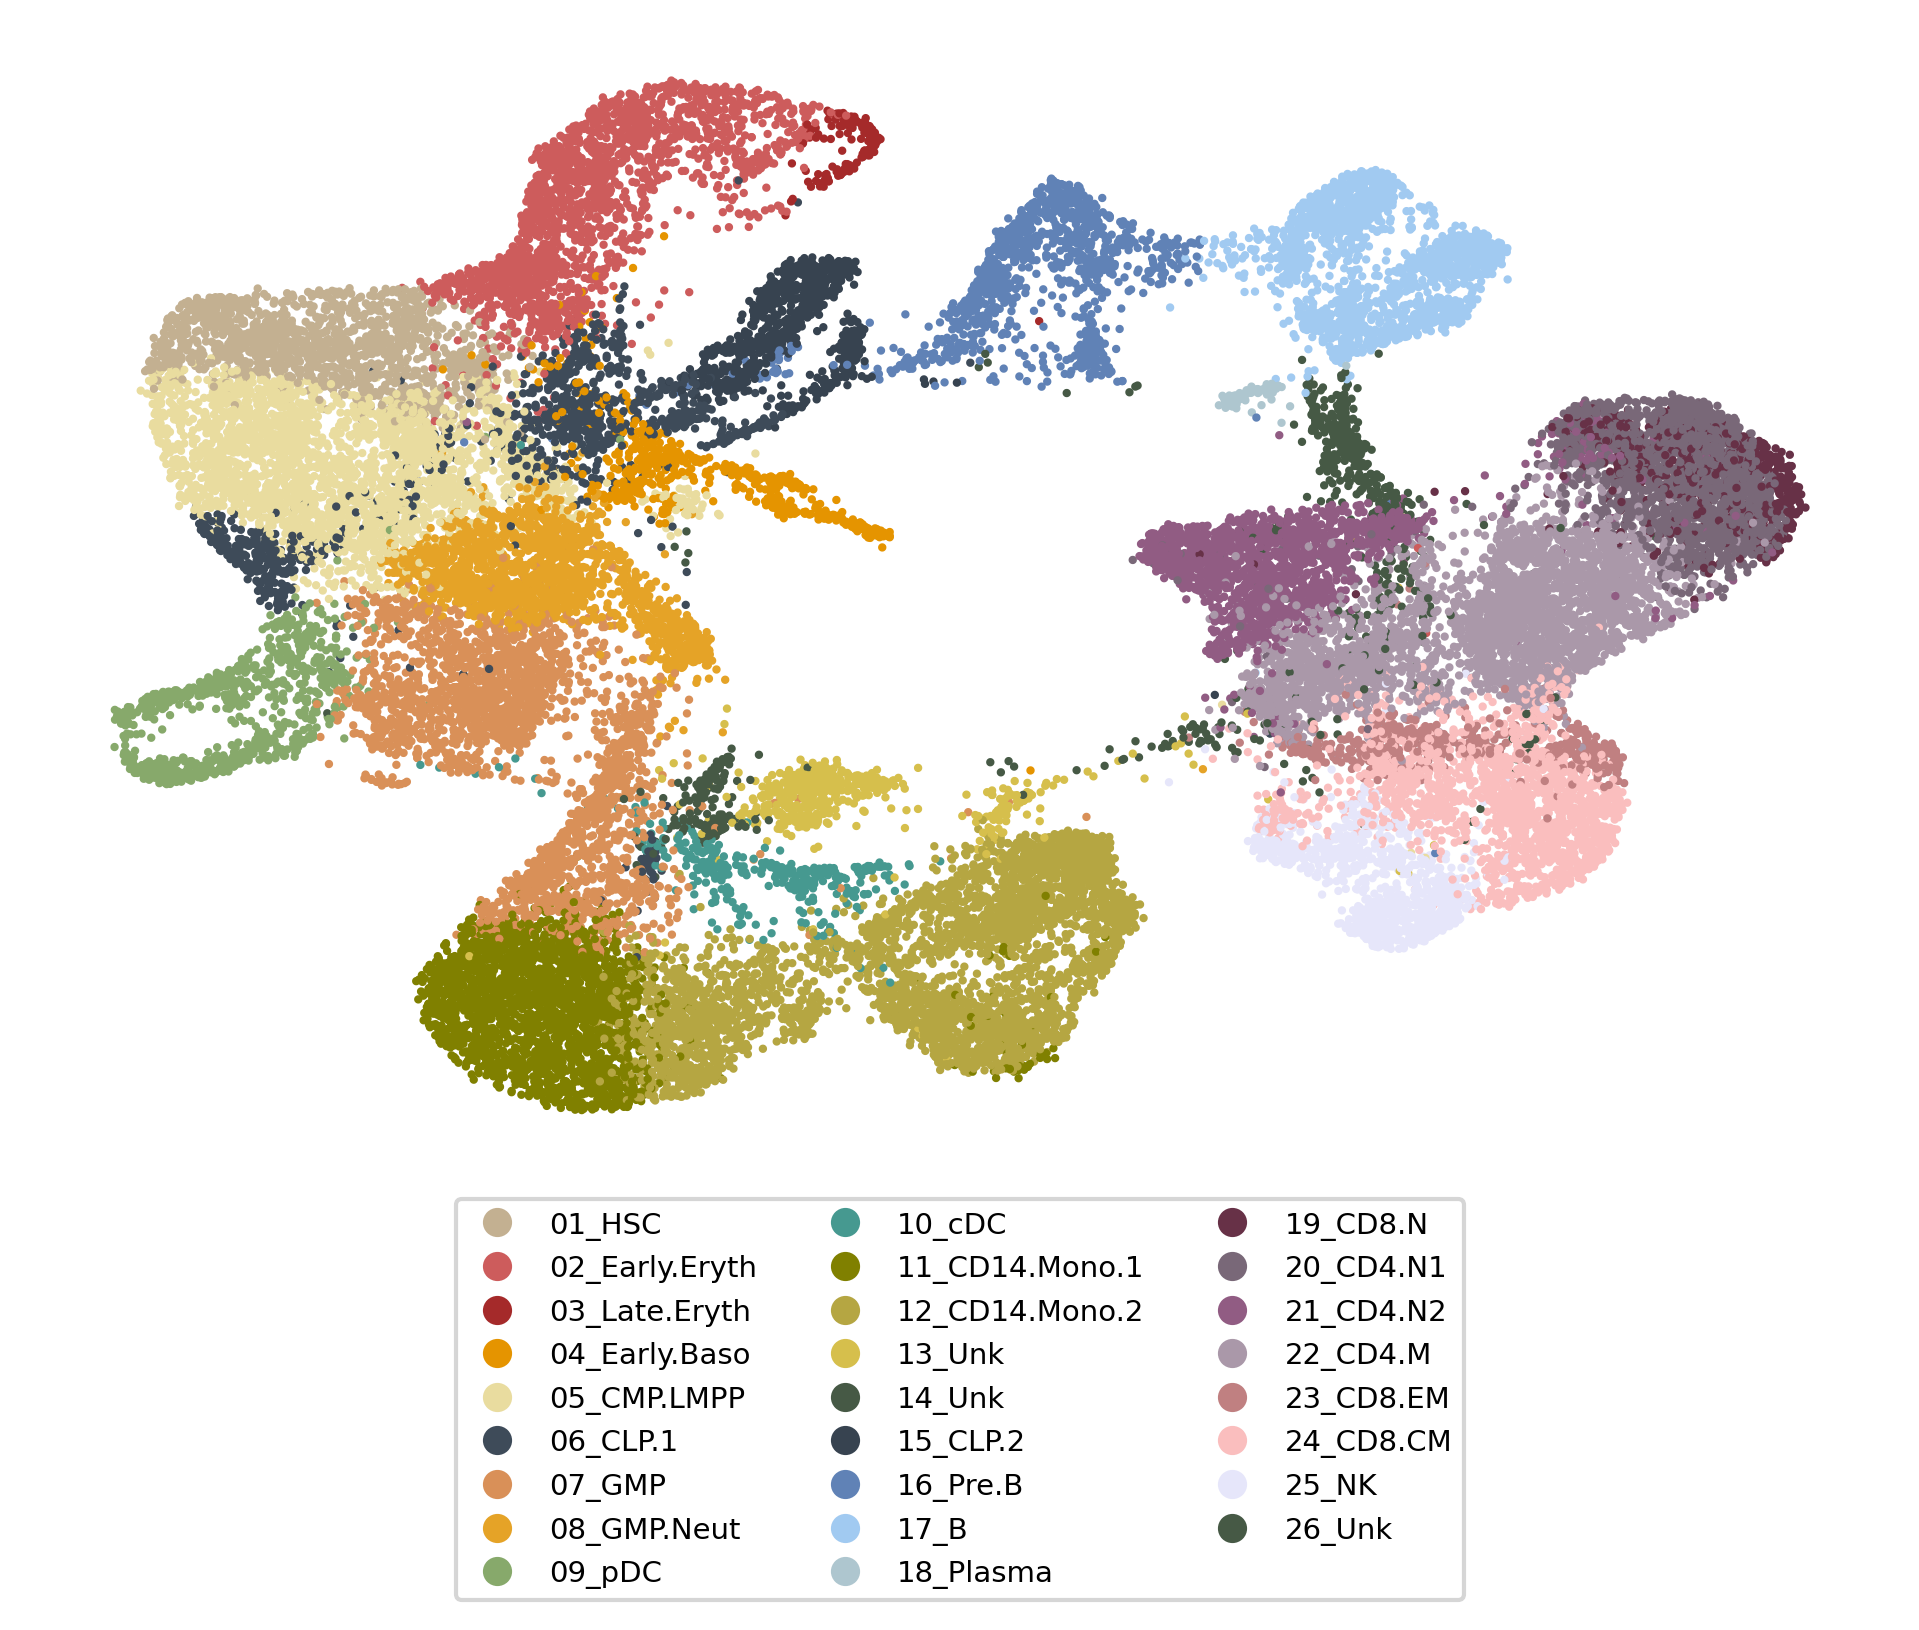

In [35]:
umap_full = np.load("../data/interim/greenleaf_scATAC_filtered_umap.npy")
plt.figure(figsize=(8, 5), dpi=300)
plt.scatter(x=umap_full[:, 0], y=umap_full[:, 1],
            s=1, c=bio_color)
plt.legend(bio_marker, bio_legend.keys(), numpoints=0.2, fontsize=7, ncol=3,
           loc="lower center", bbox_to_anchor=(0.5, -0.4))

ax = plt.axes()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

### e. Check percentage of closest genes in CellMarker

#### i. Load closest gene information from HOMER

In [36]:
HOMER = pd.read_csv("../data/processed/greenleaf_scATAC_peak_annotations_HOMER.txt", sep="\t")
HOMER["Start"] = HOMER["Start"] - 1  # adjust for HOMER default
HOMER["index"] = HOMER.Chr + "_" + HOMER.Start.astype(str) + "_" + HOMER.End.astype(str)
HOMER = HOMER.set_index("index")

#### ii. Load the CellMarker table

In [37]:
# get the cell type subset to include
cell_subset = pd.read_csv("../data/external/cell_types_in_CellMarker_subset.txt",
                          sep="\t", header=None).values.ravel().tolist()
# load the marker dataframe
cellmarker = pd.read_csv("../data/external/CellMarker_human_markers.txt",
                         sep="\t")
# subset the marker dataframe for the cell_subset
cellmarker = cellmarker.set_index("cellName")
cellmarker = cellmarker.loc[cell_subset, :]

#### iii. Extract all marker genes

In [38]:
# select all markers
marker_genes = list(cellmarker.geneSymbol.values
                   ) + list(cellmarker.cellMarker.values)
# clean up gene lists
marker_genes = [m for m in marker_genes if not isinstance(m, float)]
marker_genes = [m.split(" ") for m in marker_genes]
marker_genes = [[m.strip(",") for m in ms] for ms in marker_genes]
marker_genes = set(itertools.chain(*marker_genes))
marker_genes = [m for m in marker_genes if not m == ""]

#### iv. Get evidence levels for each gene

In [39]:
source = {k: [] for k in marker_genes}  # empty lists dict
for i, row in cellmarker.iterrows():  # for each row
    if not isinstance(row.geneSymbol, float):  # if gene symbol is not float
        g1 = row.geneSymbol.split(" ")
        g2 = row.cellMarker.split(" ")
        genes = list(g1) + list(g2)
    else:
        pass
    genes = [m.strip(",") for m in genes]
    for gene in genes:  # for each marker
        try:
            source[gene].append(row.PMID)  # append publication ID/Company
        except KeyError:
            pass

#### v. Create a list of high-confidence genes
High confidence marker genes are supported by 3 or more sources.

In [40]:
high_conf = [m for m in marker_genes if len(source[m]) >= 3]

#### vi. Get a list of significant regions

In [41]:
cutoffs = sig_interval(pscores, n_sds=20)
sigdict = sig_dictionary(escores, cutoffs)

#### vii. Get percentage of peaks whose closest gene is in CellMarker

In [42]:
pctgs = {}
for k, v in sigdict.items():
    
    pctgs[k] = {}  # initialize dictionary entry
    
    # get the closests genes
    cg1 = list(HOMER.loc[v, :]["Gene Name"].values)  # gene names

    # get a dictionary of aliases
    aliases = {}
    for g in cg1:
        try:
            alias = HOMER.loc[v, :]["Gene Alias"].values[0].split("|")
        except IndexError:
            alias = []

        if (g in aliases.keys()) and (len(aliases[g]) > 0):
            aliases[g].append(alias)
        else:
            aliases[g] = alias
    
    n_high = 0
    n_markers = 0
    for g, alias in aliases.items():  # for each gene and its aliases
        if (g in marker_genes) or any(a in marker_genes for a in alias):
            n_markers += 1
        if (g in high_conf) or any(a in high_conf for a in alias):
            n_high += 1

    n_genes = len(aliases.keys())
    if n_genes > 0:
        pctgs[k]["all"] = n_markers / n_genes * 100
        pctgs[k]["high"] = n_high / n_genes * 100

pctgs = pd.DataFrame(pctgs)
pctgs = pctgs.dropna(1)

Text(0.5, 0, 'Percentage of closest genes in CellMarker')

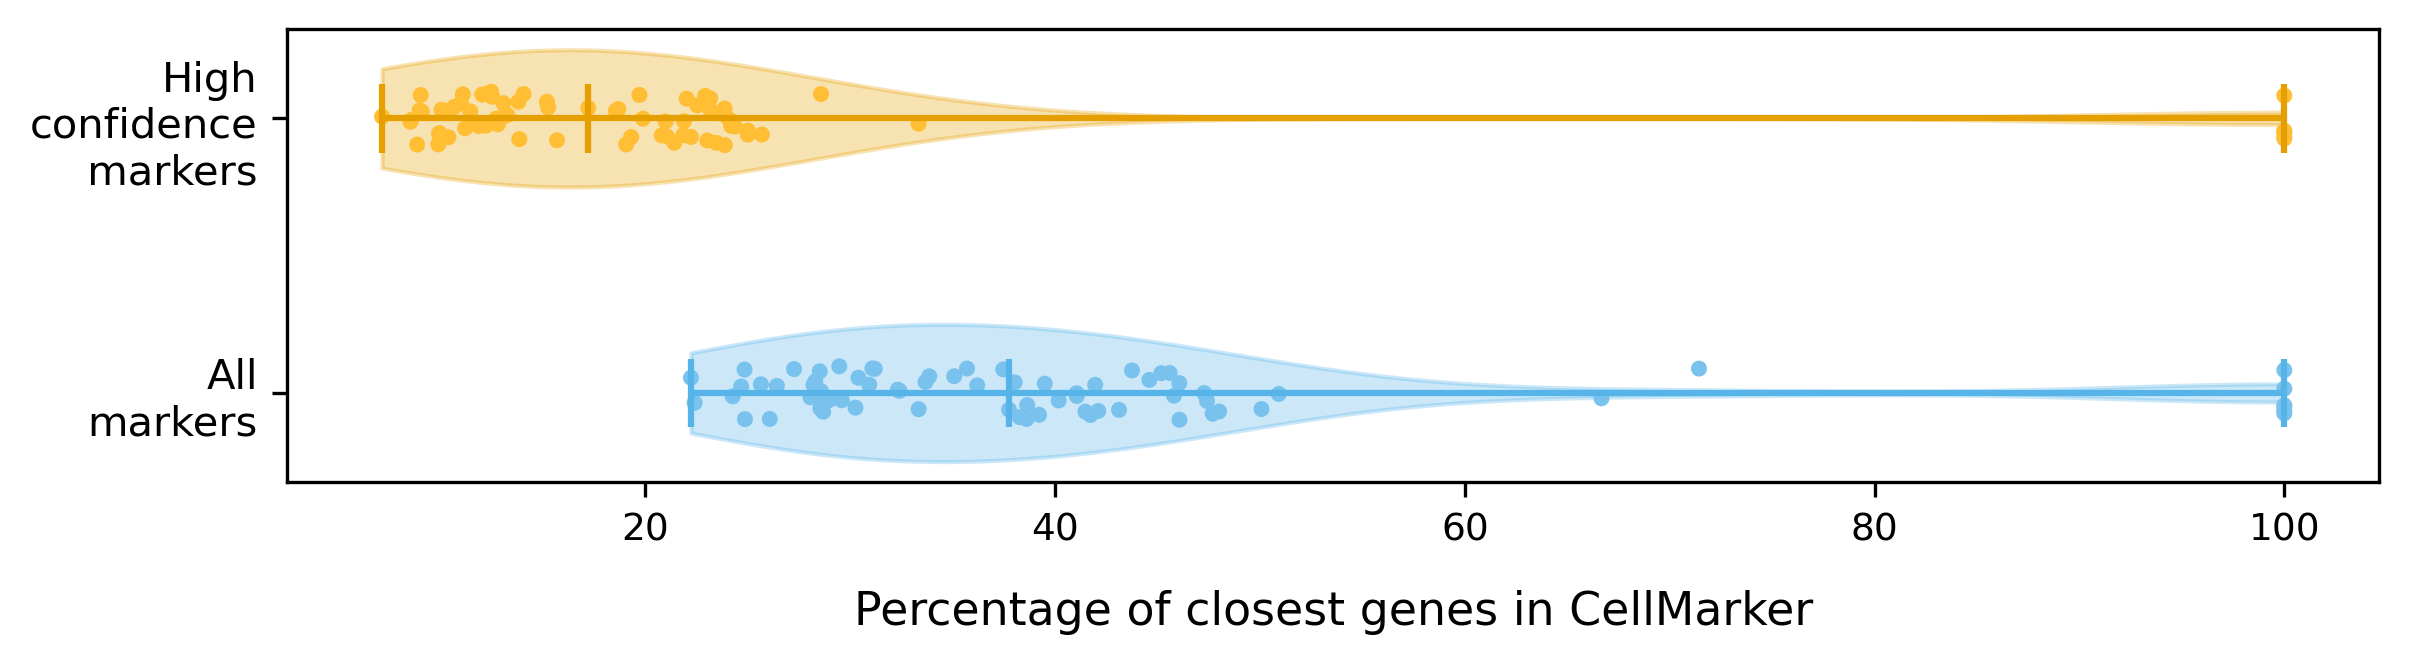

In [43]:
c2, c1, n = "#E69F00", "#56B4E9", len(pctgs.columns)
c2b, c1b = "#FFBE33", "#78C2ED"
plt.figure(figsize=(9, 2), dpi=300)
vp = plt.violinplot(pctgs, showmedians=True, vert=False)
for p, c in zip(vp["bodies"], [c1, c2]):
    p.set_facecolor(c)
    p.set_edgecolor(c)
vp["cmedians"].set_color([c1, c2])
vp["cmaxes"].set_color([c1, c2])
vp["cmins"].set_color([c1, c2])
vp["cbars"].set_color([c1, c2])

y1 = np.random.uniform(.9, 1.1, n)
y2 = y1 + 1
s = plt.scatter(x=pctgs.values, y=np.array([[y1], [y2]]), s=8,
                c=[c1b] * n + [c2b] * n)

plt.yticks([1, 2], ["All\nmarkers", "High\nconfidence\n markers"])
plt.xticks(fontsize=9)
plt.xlabel("Percentage of closest genes in CellMarker", fontsize=11,
           labelpad=10)

# plt.savefig("../figures/percentage_sig_peaks_in_CellMarker.png", dpi=300,
#             bbox_inches="tight")